In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [2]:
def count_matches(seq1, seq2):

    sites = np.arange(len(seq1))
    
    n_matches = 0
    for i in sites:
        if seq1[i] == seq2[i]:
            n_matches += 1

    return n_matches

In [3]:
def search_tata(seqs, positional=False):
    
    matches = np.zeros(7)

    if positional:
        matches_pos = np.zeros((7, 160))

    for seq in seqs:
        seq = seq.upper()
        for i in range(len(seq) - 6):
            window = seq[i:(i+6)]
            m = count_matches(window, 'TATAAT')
            matches[m] += 1
            if positional:
                matches_pos[m, i] += 1
                
    if positional:
        return matches, matches_pos
    else:
        return matches

In [4]:
def count_strong_matches(seq1, seq2, key_sites):

    matched = True
    for i in key_sites:
        if seq1[i] != seq2[i]:
            matched = False
    
    if matched:    
        n_matches = 0
        for ii in range(len(seq1)):
            if ii not in key_sites:
                if seq1[ii] == seq2[ii]:
                    n_matches += 1
    else:
        n_matches = -1

    return n_matches

In [5]:
def search_tata_strong(seqs, key_sites):

    matches = np.zeros(len(key_sites) + 1)
    matches_pos = np.zeros((len(key_sites) + 1, 160))

    for seq in seqs:
        seq = seq.upper()
        for i in range(len(seq) - 6):
            window = seq[i:(i+6)]
            m = count_strong_matches(window, 'TATAAT', key_sites)
            if m != -1:
                matches[m] += 1
                matches_pos[m, i] += 1

    return matches, matches_pos

### Finding TATA-boxes in the entire genome

In [6]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [7]:
matches = search_tata([genome])

In [8]:
print('There are {} TATA-like boxes in the E. coli genome'.format(np.sum(matches[4:])))

There are 163481.0 TATA-like boxes in the E. coli genome


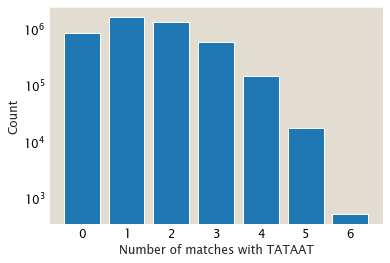

In [9]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,7,1), matches)
ax.set_yscale('log')
ax.set_xlabel('Number of matches with TATAAT')
ax.set_ylabel('Count')
plt.show()

### Find TATA-boxes in the promoters

In [10]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
df = df.drop_duplicates(subset='tss')
df.head()

,gene,promoter,gene_position,direction,tss,evidence
0,accA,accAp2,208621.0,+,208326.0,"[""none"", ""EXP""]"
1,accA,accAp1,208621.0,+,208411.0,"[""COMP"", ""EXP"", ""EXP""]"
2,accB,accBp1,3405436.0,+,3405140.0,"[""COMP"", ""EXP"", ""COMP""]"
4,accB,accBp2,3405436.0,+,3405172.0,"[""none"", ""EXP""]"
6,accD,accDp,2433926.0,-,2434015.0,"[""COMP"", ""COMP"", ""EXP""]"


In [11]:
promoters = []
for index, row in df.iterrows():
    promoter = tregs.seq_utils.get_regulatory_region(genome, int(row['tss']), reverse=True)
    promoters.append(promoter)

In [12]:
matches_promoters = search_tata(promoters)

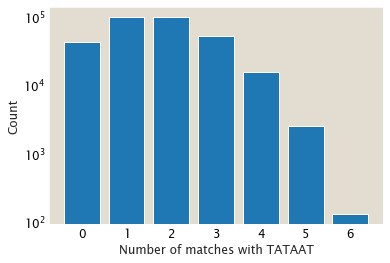

In [13]:
fig, ax = plt.subplots()
ax.bar(np.arange(0,7,1), matches_promoters)
ax.set_yscale('log')
ax.set_xlabel('Number of matches with TATAAT')
ax.set_ylabel('Count')
plt.show()

In [14]:
np.sum(matches_promoters[4:]) / np.sum(matches_promoters) * 100

5.903245173318166

### Plotting the position of the TATAAT boxes

In [15]:
matches, pos = search_tata(promoters, positional=True)

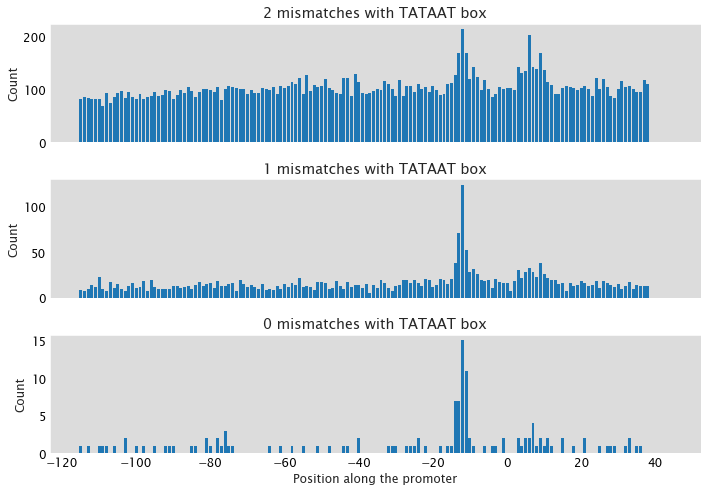

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(10,7),
                         sharex=True)

for i in range(3):
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_facecolor("gainsboro")
    
for i in range(3):
    axes[i].bar(np.arange(-115, 45), pos[4:][i, :], linewidth=0)
    axes[i].set_title('{} mismatches with TATAAT box'.format(2-i))
    axes[i].set_ylabel('Count', fontsize=12)

axes[-1].set_xlabel('Position along the promoter', fontsize=12)

plt.tight_layout()
plt.show()

### Counting the number of mismatches after enforcing the TAXXXT motif

In [17]:
matches_strong, pos_strong = search_tata_strong(promoters, key_sites=[0, 1, 5])

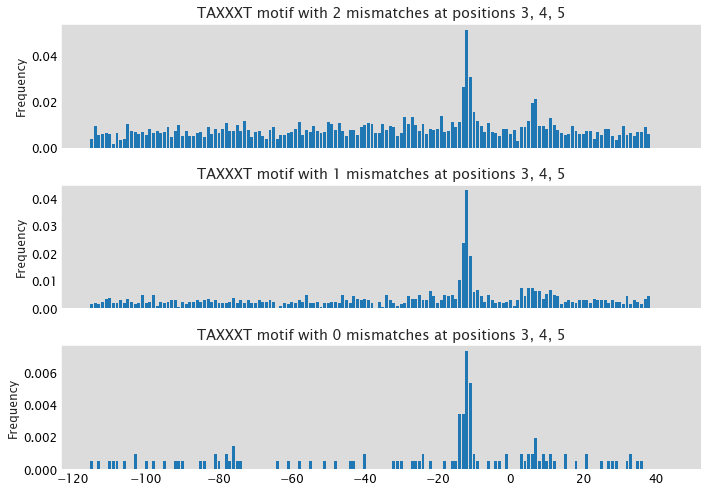

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(10,7),
                         sharex=True)

for i in range(3):
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_facecolor("gainsboro")


for i in range(3):
    axes[i].bar(np.arange(-115, 45), pos_strong[1:][i, :] / len(promoters), linewidth=0)
    axes[i].set_title('TAXXXT motif with {} mismatches at positions 3, 4, 5'.format(3-i-1))


#axes[-1].bar(np.arange(-115, 45), pos[4:][2, :] / len(promoters), linewidth=0)
#axes[-1].set_xlabel('Position along the promoter', fontsize=12)
#axes[-1].set_title('Perfect TATAAT boxes')

plt.tight_layout()
plt.savefig('../../manuscript/figures/plots/fig13/tata_boxes.png', dpi=300, bbox_inches='tight')
plt.show()